SVM's take a set of n dim vectors will labeled classes, e.g. standard scalar rates of output for each trial. 
you then have different choices of kernel, can check all of these
regularization values are tuneable


In [17]:
import os
import pickle
import time
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
l_al = []
l_ar = []
r_al = []
r_ar = []
sc_al = []
sc_ar = []

def load_and_split(file_numbers):
    total_time = time.time()
    for file_number in  file_numbers:
        file_total = time.time()
        file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
        load_data_start_time = time.time()
        data = pickle.load(open(file_path, 'rb'))
        elapsed_time = time.time() - load_data_start_time
        print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

        attend_01 = data['attend'][0]
        omitted = data['omit'][0]

        left_input_SP = data['SP'][0][0]
        right_input_SP = data['SP'][0][1]
        attention_SP = data['SP'][0][2]

        left_indices = np.where((attend_01 == 0) & (omitted == 0))[0]
        right_indices = np.where((attend_01 == 1) & (omitted == 0))[0]
                                    
        l_al.append(np.sum(left_input_SP[left_indices, 100:350, :], axis = 1))
        r_al.append(np.sum(right_input_SP[left_indices, 100:350, :], axis = 1))

        l_ar.append(np.sum(left_input_SP[right_indices, 100:350, :], axis = 1))
        r_ar.append(np.sum(right_input_SP[right_indices, 100:350, :], axis = 1))
        
        #finding spike counts per neuron per trial
        sc_al.append(np.sum(attention_SP[left_indices, 100:350, :], axis = 1))
        sc_ar.append(np.sum(attention_SP[right_indices, 100:350, :], axis = 1))

        print(f"Dataset {file_number} processed in {time.time() - file_total:.2f} seconds")
    print(f"All datasets processed in {time.time() - total_time:.2f} seconds")


In [11]:
load_and_split([1, 2])

Dataset 1 loaded in 11.07 seconds
Dataset 1 processed in 11.66 seconds
Dataset 2 loaded in 15.79 seconds
Dataset 2 processed in 16.89 seconds
All datasets processed in 28.55 seconds


In [13]:
l_al_flat = np.concatenate(l_al, axis=0)
l_ar_flat = np.concatenate(l_ar, axis=0)

r_al_flat = np.concatenate(r_al, axis=0)
r_ar_flat = np.concatenate(r_ar, axis=0)

sc_al_flat = np.concatenate(sc_al, axis=0)
sc_ar_flat = np.concatenate(sc_ar, axis=0)

print(l_al[0].shape)
print(l_al[1].shape)
print(l_al_flat.shape)

print(r_al_flat.shape)


print(sc_al_flat.shape)

(495, 160)
(488, 160)
(983, 160)
(983, 160)
(983, 80)


In [46]:
def plot_in_vs_out(in_vals, out_vals,
                   labels=('In','Out'),
                   ylabel='Pearson r',
                   title=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    #tells boxplot to draw filled boxes (patch_artist=True)
    bp = ax.boxplot([in_vals, out_vals],
                    widths=0.6,
                    notch=False,
                    patch_artist=True)
    
    # color sequence: C0 is blue, C1 is orange in the default Matplotlib cycle
    colors = ['C0','C1']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # (optional) make whiskers/caps match box edge
    for element in ['whiskers','caps']:
        for line in bp[element]:
            line.set(color='k')
    
    #median line already black by default, but you can customize:
    for median in bp['medians']:
        median.set(color='k', linewidth=1)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)
    ax.set_ylim(np.min(in_vals + out_vals / 2) * 0.9, np.max(in_vals + out_vals / 2) * 1.1)
    if title:
        ax.set_title(title)
    plt.tight_layout()

In [29]:
def run_svr(X, Y, pca_components=[10, 20, 50]):
    print('x shape', X.shape)
    print('y shape', Y.shape)
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # Build a pipeline: scaling -> PCA -> multi-output SVR
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('multi_svr', MultiOutputRegressor(SVR()))
    ])

    # Grid search over PCA components and SVR hyperparameters
    param_grid = {
        'pca__n_components': pca_components,
        'multi_svr__estimator__C': [1, 10],
        'multi_svr__estimator__epsilon': [0.1, 0.5],
        'multi_svr__estimator__gamma': ['scale', 'auto'],
    }

    grid = GridSearchCV(
        pipeline, param_grid, cv=3,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # Best pipeline parameters
    print("Best parameters:", grid.best_params_)

    # Evaluate on test set
    y_pred = grid.predict(X_test)
    rmse_per_neuron = np.sqrt(np.mean((y_pred - y_test)**2, axis=0))

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")

    return grid.best_estimator_, rmse_per_neuron

# You can now use `grid.best_estimator_` to make predictions on new data.

_, l_al_errors = run_svr(l_al_flat, sc_al_flat)
_, r_ar_errors = run_svr(r_ar_flat, sc_ar_flat)

_, r_al_errors = run_svr(r_al_flat, sc_al_flat)
_, l_ar_errors = run_svr(l_ar_flat, sc_ar_flat)



x shape (983, 160)
y shape (983, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'scale', 'pca__n_components': 50}
Test MSE: 36.6334
Test R²: 0.4839
x shape (983, 160)
y shape (983, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'scale', 'pca__n_components': 10}
Test MSE: 37.0995
Test R²: 0.2908
x shape (1064, 160)
y shape (1064, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'scale', 'pca__n_components': 20}
Test MSE: 45.7547
Test R²: 0.4600
x shape (1064, 160)
y shape (1064, 80)
Best parameters: {'multi_svr__estimator__C': 10, 'multi_svr__estimator__epsilon': 0.5, 'multi_svr__estimator__gamma': 'scale', 'pca__n_components': 50}
Test MSE: 40.7874
Test R²: 0.4998


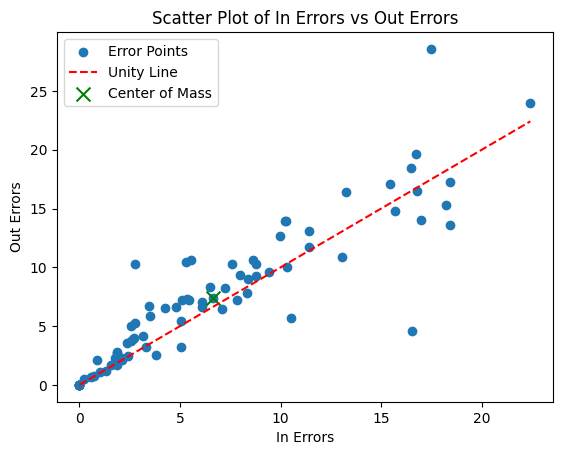

In [30]:
in_errors = l_al_errors + r_ar_errors / 2
out_errors = l_ar_errors + r_al_errors / 2

import matplotlib.pyplot as plt

plt.scatter(in_errors, out_errors, label='Error Points')
plt.plot([min(in_errors), max(in_errors)], [min(in_errors), max(in_errors)], 'r--', label='Unity Line')

# Calculate and plot the center of mass
center_of_mass_x = np.mean(in_errors)
center_of_mass_y = np.mean(out_errors)
plt.scatter(center_of_mass_x, center_of_mass_y, color='green', label='Center of Mass', s=100, marker='x')

plt.xlabel('In Errors')
plt.ylabel('Out Errors')
plt.title('Scatter Plot of In Errors vs Out Errors')
plt.legend()
plt.show()

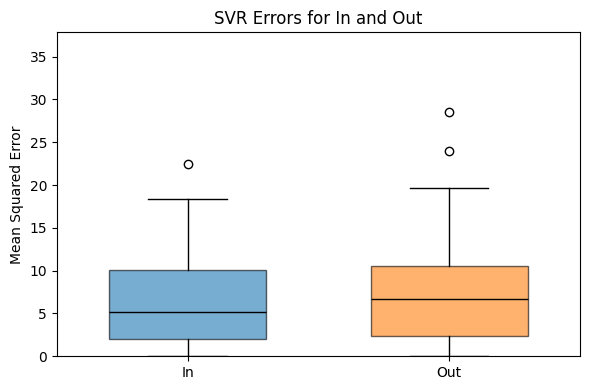

In [47]:
plot_in_vs_out(in_errors, out_errors,
               labels=('In','Out'),
               ylabel='Mean Squared Error',
               title='SVR Errors for In and Out')

X shape: (983, 160)
Y shape: (983, 80)
Best alpha: 10.0
Overall test MSE: 35.4642
Overall test R²: 0.6542
X shape: (1064, 160)
Y shape: (1064, 80)
Best alpha: 100.0
Overall test MSE: 38.7574
Overall test R²: 0.6288
X shape: (983, 160)
Y shape: (983, 80)
Best alpha: 100.0
Overall test MSE: 33.4047
Overall test R²: 0.5612
X shape: (1064, 160)
Y shape: (1064, 80)
Best alpha: 100.0
Overall test MSE: 44.4923
Overall test R²: 0.5721


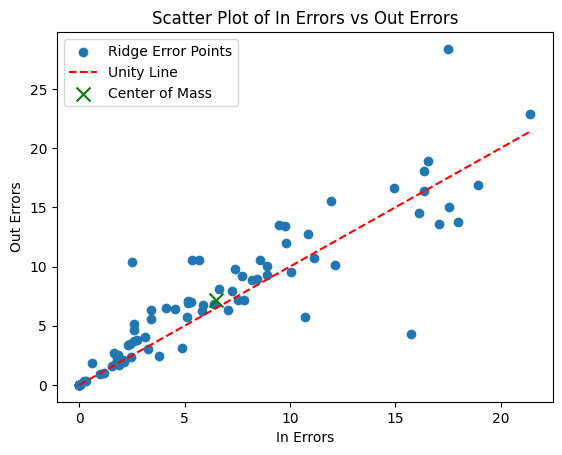

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

def run_ridge(X, Y, alphas=[0.1, 1.0, 10.0, 100.0], test_size=0.2, random_state=42):
    """
    Train a multi-output Ridge regression on X (n_samples, n_features)
    to predict Y (n_samples, n_targets). Returns the best estimator and
    per-target MSE on the held-out test set.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
    - Y: array-like, shape (n_samples, n_targets)
    - alphas: list of regularization strengths to grid-search
    - test_size: fraction of data to hold out for testing
    - random_state: for reproducibility

    Returns:
    - best_model: fitted GridSearchCV.best_estimator_
    - mse_per_target: array of shape (n_targets,) with test MSE per target
    """
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)

    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Set up multi-output Ridge wrapped in GridSearchCV
    ridge = MultiOutputRegressor(Ridge())
    param_grid = {'estimator__alpha': alphas}

    grid = GridSearchCV(
        ridge, param_grid, cv=3,
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = grid.predict(X_test_scaled)

    # Compute per-target MSE
    rmse_per_target = np.sqrt(np.mean((y_pred - y_test) ** 2, axis=0))

    # Overall metrics
    overall_mse = mean_squared_error(y_test, y_pred)
    overall_r2  = r2_score(y_test, y_pred)

    print("Best alpha:", grid.best_params_['estimator__alpha'])
    print(f"Overall test MSE: {overall_mse:.4f}")
    print(f"Overall test R²: {overall_r2:.4f}")

    return grid.best_estimator_, rmse_per_target


best_ridge_lal, ridge_errors_lal = run_ridge(l_al_flat, sc_al_flat)
best_ridge_rar, ridge_errors_rar = run_ridge(r_ar_flat, sc_ar_flat)

best_ridge_ral, ridge_errors_ral = run_ridge(r_al_flat, sc_al_flat)
best_ridge_lar, ridge_errors_lar = run_ridge(l_ar_flat, sc_ar_flat)


in_ridge_errors = ridge_errors_lal + ridge_errors_rar / 2
out_ridge_errors = ridge_errors_lar + ridge_errors_ral / 2

plt.scatter(in_ridge_errors, out_ridge_errors, label='Ridge Error Points')
plt.plot([min(in_ridge_errors), max(in_ridge_errors)], [min(in_ridge_errors), max(in_ridge_errors)], 'r--', label='Unity Line')
# Calculate and plot the center of mass
center_of_mass_x = np.mean(in_ridge_errors)
center_of_mass_y = np.mean(out_ridge_errors)
plt.scatter(center_of_mass_x, center_of_mass_y, color='green', label='Center of Mass', s=100, marker='x')
plt.xlabel('In Errors')
plt.ylabel('Out Errors')
plt.title('Scatter Plot of In Errors vs Out Errors')
plt.legend()
plt.show()


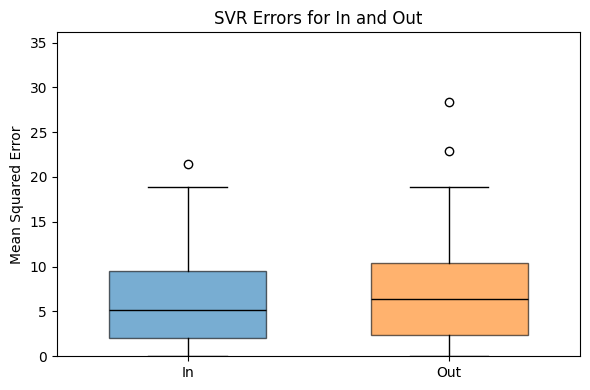

In [49]:
plot_in_vs_out(in_ridge_errors, out_ridge_errors,
               labels=('In','Out'),
               ylabel='Mean Squared Error',
               title='SVR Errors for In and Out')

In [ ]:
in_mlp_errors = mlp_errors_lal + mlp_errors_rar / 2
out_mlp_errors = mlp_errors_lar + mlp_errors_ral / 2

plt.scatter(in_mlp_errors, out_mlp_errors, label='MLP Error Points')
plt.plot([min(in_mlp_errors), max(in_mlp_errors)], [min(in_mlp_errors), max(in_mlp_errors)], 'r--', label='Unity Line')
# Calculate and plot the center of mass
center_of_mass_x = np.mean(in_mlp_errors)
center_of_mass_y = np.mean(out_mlp_errors)
plt.scatter(center_of_mass_x, center_of_mass_y, color='green', label='Center of Mass', s=100, marker='x')
plt.xlabel('In Errors')
plt.ylabel('Out Errors')
plt.title('Scatter Plot of In Errors vs Out Errors')
plt.legend()
plt.show()

plot_in_vs_out(in_mlp_errors, out_mlp_errors,
                labels=('In','Out'),
                ylabel='Mean Squared Error',
                title='SVR Errors for In and Out')